### Density Aware K-Means 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]
X.head()

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)

labels_km = kmeans.labels_
centers_km = kmeans.cluster_centers_

In [6]:
df['KMeans_Cluster'] = labels_km
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),KMeans_Cluster
0,1,Male,19,15,39,4
1,2,Male,21,15,81,2
2,3,Female,20,16,6,4
3,4,Female,23,16,77,2
4,5,Female,31,17,40,4


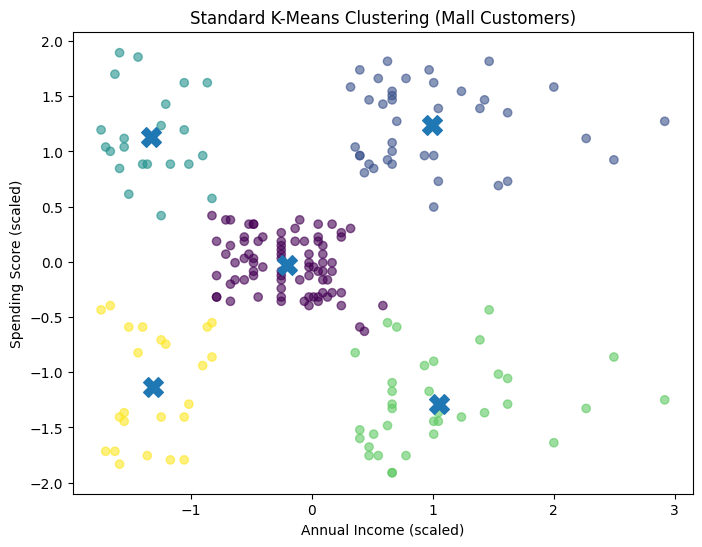

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=labels_km, alpha=0.6)
plt.scatter(centers_km[:,0], centers_km[:,1], marker='X', s=200)
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.title("Standard K-Means Clustering (Mall Customers)")
plt.show()

In [8]:
pd.DataFrame(
    centers_km, 
    columns=['Annual Income (scaled)', 'Spending Score (scaled)']
)

,Annual Income (scaled),Spending Score (scaled)
0,-0.200913,-0.026456
1,0.991583,1.239503
2,-1.329545,1.132178
3,1.055003,-1.284439
4,-1.307519,-1.136965


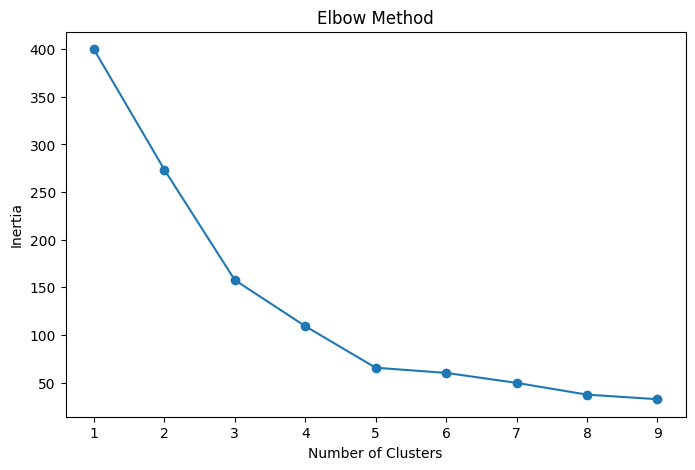

In [9]:
inertia = []
k_range = range(1,10)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin

In [13]:
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [14]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]
X.head()

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
class DensityAwareKMeans:
    def __init__(self, n_clusters=5, max_iter=100, tol=1e-4, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X):
        rng = np.random.default_rng(self.random_state)
        indices = rng.choice(len(X), size=self.n_clusters, replace=False)
        self.cluster_centers_ = X[indices]

        for _ in range(self.max_iter):

            labels = pairwise_distances_argmin(X, self.cluster_centers_)

            densities = []
            for i in range(self.n_clusters):
                pts = X[labels == i]
                if len(pts) == 0:
                    densities.append(np.inf)
                    continue
                densities.append(np.mean(np.linalg.norm(pts - self.cluster_centers_[i], axis=1)))

            densities = np.array(densities)

            inv_dens = 1 / (densities + 1e-9)
            weights = inv_dens / np.sum(inv_dens)

            new_centers = np.copy(self.cluster_centers_)
            for i in range(self.n_clusters):
                pts = X[labels == i]
                if len(pts) > 0:
                    new_centers[i] = np.average(pts, axis=0, weights=np.full(len(pts), weights[i]))

            if np.linalg.norm(new_centers - self.cluster_centers_) < self.tol:
                break

            self.cluster_centers_ = new_centers

        self.labels_ = pairwise_distances_argmin(X, self.cluster_centers_)
        return self

In [17]:
dam = DensityAwareKMeans(n_clusters=5, random_state=42)
dam.fit(X_scaled)

labels_dam = dam.labels_
centers_dam = dam.cluster_centers_

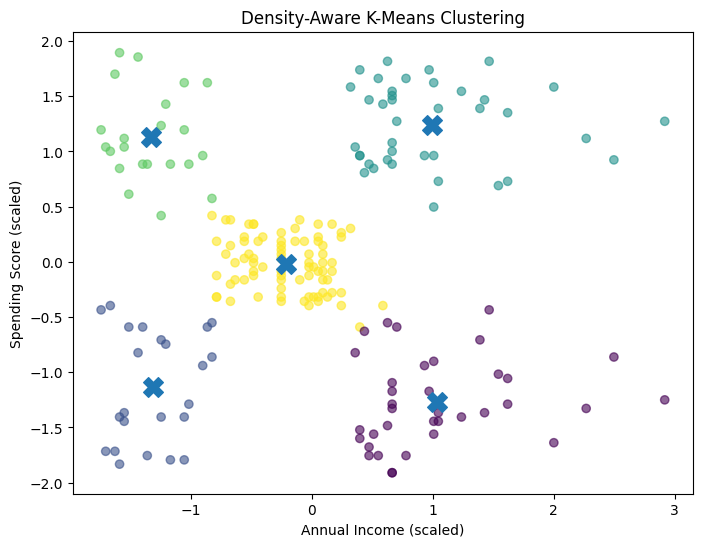

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=labels_dam, alpha=0.6)
plt.scatter(centers_dam[:,0], centers_dam[:,1], marker='X', s=200)
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.title("Density-Aware K-Means Clustering")
plt.show()

In [20]:
pd.DataFrame(
    centers_dam,
    columns=['Annual Income (scaled)', 'Spending Score (scaled)']
)

,Annual Income (scaled),Spending Score (scaled)
0,1.037827,-1.266230
1,-1.307519,-1.136965
2,0.991583,1.239503
3,-1.329545,1.132178
4,-0.208882,-0.018926


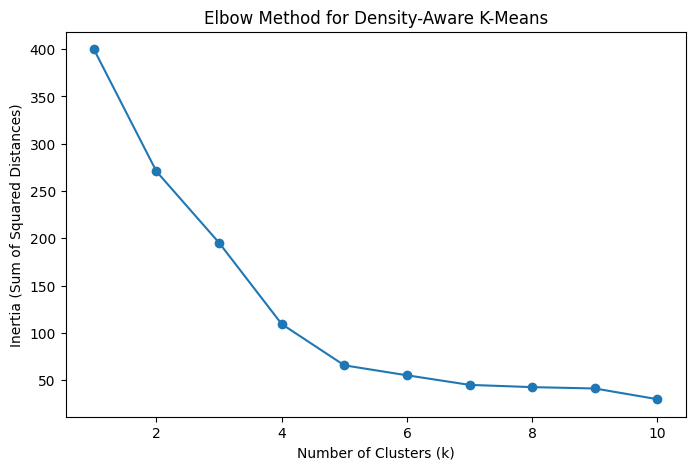

In [21]:
inertia_dam = []
k_range = range(1, 11)

for k in k_range:
    dam_k = DensityAwareKMeans(n_clusters=k, random_state=42)
    dam_k.fit(X_scaled)

    # Calculate inertia manually (sum of squared distances to cluster center)
    total_dist = 0
    for i in range(k):
        pts = X_scaled[dam_k.labels_ == i]
        if len(pts) > 0:
            total_dist += np.sum((pts - dam_k.cluster_centers_[i])**2)

    inertia_dam.append(total_dist)

# Plot the elbow curve
plt.figure(figsize=(8,5))
plt.plot(k_range, inertia_dam, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Density-Aware K-Means")
plt.show()

#### Comparision of K-means and Density Aware K-means CLustering

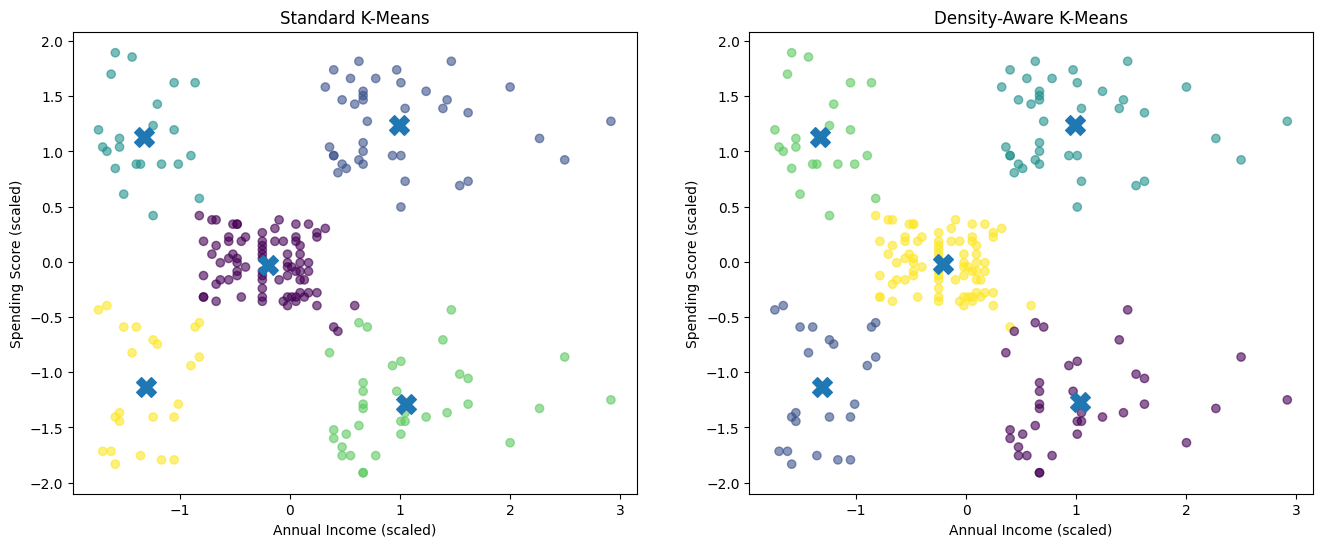

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))

# ---- Standard K-Means ----
ax[0].scatter(
    X_scaled[:, 0], X_scaled[:, 1], 
    c=labels_km, alpha=0.6
)
ax[0].scatter(
    centers_km[:, 0], centers_km[:, 1], 
    marker='X', s=200
)
ax[0].set_title("Standard K-Means")
ax[0].set_xlabel("Annual Income (scaled)")
ax[0].set_ylabel("Spending Score (scaled)")

# ---- Density-Aware K-Means ----
ax[1].scatter(
    X_scaled[:, 0], X_scaled[:, 1], 
    c=labels_dam, alpha=0.6
)
ax[1].scatter(
    centers_dam[:, 0], centers_dam[:, 1], 
    marker='X', s=200
)
ax[1].set_title("Density-Aware K-Means")
ax[1].set_xlabel("Annual Income (scaled)")
ax[1].set_ylabel("Spending Score (scaled)")

plt.show()
